# Notebook to prepare dataset for training and evaluation

In [1]:
import json
import os
import shutil
from tqdm import tqdm
import copy
import numpy as np
from pathlib import Path
from collections import defaultdict

## Creating train/test splits

### Combine in- and out-system trash classes into one class for YOLO training

In [2]:
with open('./data/annotations/all_annotations.json', 'r') as f:
    all_annotations = json.load(f)
combined = copy.deepcopy(all_annotations)

print(combined['categories'])
del combined['categories'][1]
print(combined['categories'])

for i, cat in enumerate(combined['categories']):
    cat['id'] = i+1
print(combined['categories'])

cat_remap = {1 : 1, 2: 1, 3: 2, 4: 3}
for annotation in tqdm(combined['annotations']):
    annotation['category_id'] = cat_remap[annotation['category_id']]
    
all_annotations = copy.deepcopy(combined)

[{'id': 1, 'name': 'floating_trash_in_system', 'supercategory': ''}, {'id': 2, 'name': 'floating_trash_outside_system', 'supercategory': ''}, {'id': 3, 'name': 'water', 'supercategory': ''}, {'id': 4, 'name': 'barrier', 'supercategory': ''}]
[{'id': 1, 'name': 'floating_trash_in_system', 'supercategory': ''}, {'id': 3, 'name': 'water', 'supercategory': ''}, {'id': 4, 'name': 'barrier', 'supercategory': ''}]
[{'id': 1, 'name': 'floating_trash_in_system', 'supercategory': ''}, {'id': 2, 'name': 'water', 'supercategory': ''}, {'id': 3, 'name': 'barrier', 'supercategory': ''}]


100%|██████████| 4387/4387 [00:00<00:00, 876001.51it/s]


### Collect annotations and image information per split

In [3]:
def move_images(traintest, splits, source_folder, target_folder):
    for target_image in splits[traintest]:
        location_id = target_image.split('_')[0]
        target_id = target_image[2:]

        shutil.copy(f'{source_folder}/loc{location_id}/{target_id}', f'{target_folder}/{traintest}/images/{target_id}')

def collect_annotations(all_annotations, split_images_path):
    # Collect image ids for annotations per split
    image_info = [x for x in all_annotations['images'] if x['file_name'] in os.listdir(split_images_path)] 
    image_ids = [x['id'] for x in image_info]
    annotations = [x for x in all_annotations['annotations'] if x['image_id'] in image_ids]
    return image_info, annotations

def replace_images_annotations(full_annotations, new_images, new_annotations):
    full_annotations['images'] = new_images
    full_annotations['annotations'] = new_annotations
    return full_annotations

In [7]:
with open('./data/annotations/split_mapping.json', 'r') as f:
    split_mapping = json.load(f)

for split_id, splits in tqdm(split_mapping.items()):
    # Create folders for test and train images
    split_folder = f'./data/annotations/{split_id}'
    train_imgs_path, test_imgs_path = f'{split_folder}/train/images', f'{split_folder}/test/images'
    os.makedirs(train_imgs_path, exist_ok=True)
    os.makedirs(test_imgs_path, exist_ok=True)

    # Move correct images to the folders
    move_images('train', splits, './data/images', split_folder)
    move_images('test', splits, './data/images', split_folder)
    
    # Collect annotation information per split
    train_images, train_annotations = collect_annotations(all_annotations, train_imgs_path)
    test_images, test_annotations = collect_annotations(all_annotations, test_imgs_path)

    # Replace annotation and image information per split. Licenses, info and categories stay the same
    train = replace_images_annotations(copy.deepcopy(all_annotations), train_images, train_annotations)
    test = replace_images_annotations(copy.deepcopy(all_annotations), test_images, test_annotations)
    
    # Save new annotations information
    with open(f'{split_folder}/train/annotations.json', 'w+') as f:
        json.dump(train, f)
    with open(f'{split_folder}/test/annotations.json', 'w+') as f:
        json.dump(test, f)

100%|██████████| 8/8 [00:41<00:00,  5.17s/it]


### Convert COCO format to YOLO format
At the time of writing, there is an issue with training Ultralytics models using COCO-format data. Thus, we need to first convert to YOLO format.

In [8]:
"""Code from https://github.com/ultralytics/JSON2YOLO"""
def convert_coco_json(json_dir, use_segments=True, cls91to80=False):
    """Converts COCO JSON format to YOLO label format, with options for segments and class mapping."""
    # Make 'labels' subdirectory in the same directory as json dir
    fn = f'{json_dir}/labels'
    os.makedirs(fn, exist_ok=True)

    # Import json in the json dir
    json_file = sorted(Path(json_dir).resolve().glob("*.json"))[0]
    print('Using', json_file)

    with open(json_file) as f:
        data = json.load(f)

    # Create image dict
    images = {x["id"]: x for x in data["images"]}

    # Create image-annotations dict
    imgToAnns = defaultdict(list)
    for ann in data["annotations"]:
        imgToAnns[ann["image_id"]].append(ann)

    # Write labels file
    for img_id, anns in tqdm(imgToAnns.items(), desc=f"Annotations {json_file}"):
        img = images[img_id]
        h, w, f = img["height"], img["width"], img["file_name"]

        bboxes = []
        segments = []
        for ann in anns:
            if ann["iscrowd"]:
                continue
            # The COCO box format is [top left x, top left y, width, height]
            box = np.array(ann["bbox"], dtype=np.float64)
            box[:2] += box[2:] / 2  # xy top-left corner to center
            box[[0, 2]] /= w  # normalize x
            box[[1, 3]] /= h  # normalize y
            if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                continue

            cls = ann["category_id"] - 1  # class
            box = [cls] + box.tolist()
            if box not in bboxes:
                bboxes.append(box)
            # Segments
            if use_segments:
                if len(ann["segmentation"]) > 1:
                    s = merge_multi_segment(ann["segmentation"])
                    s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                else:
                    s = [j for i in ann["segmentation"] for j in i]  # all segments concatenated
                    s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
                s = [cls] + s
                if s not in segments:
                    segments.append(s)

        # Write
        with open(f'{fn}/{f.replace(".jpg", ".txt")}', "a") as file:
            for i in range(len(bboxes)):
                line = (*(segments[i] if use_segments else bboxes[i]),)  # cls, box or segments
                file.write(("%g " * len(line)).rstrip() % line + "\n")

def merge_multi_segment(segments):
    """
    Merge multi segments to one list. Find the coordinates with min distance between each segment, then connect these
    coordinates with one thin line to merge all segments into one.

    Args:
        segments(List(List)): original segmentations in coco's json file.
            like [segmentation1, segmentation2,...],
            each segmentation is a list of coordinates.
    """
    s = []
    segments = [np.array(i).reshape(-1, 2) for i in segments]
    idx_list = [[] for _ in range(len(segments))]

    # record the indexes with min distance between each segment
    for i in range(1, len(segments)):
        idx1, idx2 = min_index(segments[i - 1], segments[i])
        idx_list[i - 1].append(idx1)
        idx_list[i].append(idx2)

    # use two round to connect all the segments
    for k in range(2):
        # forward connection
        if k == 0:
            for i, idx in enumerate(idx_list):
                # middle segments have two indexes
                # reverse the index of middle segments
                if len(idx) == 2 and idx[0] > idx[1]:
                    idx = idx[::-1]
                    segments[i] = segments[i][::-1, :]

                segments[i] = np.roll(segments[i], -idx[0], axis=0)
                segments[i] = np.concatenate([segments[i], segments[i][:1]])
                # deal with the first segment and the last one
                if i in [0, len(idx_list) - 1]:
                    s.append(segments[i])
                else:
                    idx = [0, idx[1] - idx[0]]
                    s.append(segments[i][idx[0] : idx[1] + 1])

        else:
            for i in range(len(idx_list) - 1, -1, -1):
                if i not in [0, len(idx_list) - 1]:
                    idx = idx_list[i]
                    nidx = abs(idx[1] - idx[0])
                    s.append(segments[i][nidx:])
    return s

def min_index(arr1, arr2):
    """
    Find a pair of indexes with the shortest distance.

    Args:
        arr1: (N, 2).
        arr2: (M, 2).
    Return:
        a pair of indexes(tuple).
    """
    dis = ((arr1[:, None, :] - arr2[None, :, :]) ** 2).sum(-1)
    return np.unravel_index(np.argmin(dis, axis=None), dis.shape)

In [10]:
for split in os.listdir('./data/annotations'):
    if '.json' in split:
        continue
    for traintest in ['train', 'test']:
        convert_coco_json(f'./data/annotations/{split}/{traintest}')

Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_10_90\train\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_10_90\train\annotations.json: 100%|██████████| 30/30 [00:00<00:00, 234.29it/s]

Using

 C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_10_90\test\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_10_90\test\annotations.json: 100%|██████████| 270/270 [00:00<00:00, 367.82it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_20_80\train\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_20_80\train\annotations.json: 100%|██████████| 60/60 [00:00<00:00, 218.85it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_20_80\test\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_20_80\test\annotations.json: 100%|██████████| 240/240 [00:00<00:00, 352.38it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_30_70\train\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_30_70\train\annotations.json: 100%|██████████| 90/90 [00:00<00:00, 177.26it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_30_70\test\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_30_70\test\annotations.json: 100%|██████████| 210/210 [00:00<00:00, 362.41it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_40_60\train\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_40_60\train\annotations.json: 100%|██████████| 120/120 [00:00<00:00, 299.61it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_40_60\test\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_40_60\test\annotations.json: 100%|██████████| 180/180 [00:00<00:00, 349.46it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_50_50\train\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_50_50\train\annotations.json: 100%|██████████| 150/150 [00:00<00:00, 304.59it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_50_50\test\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_50_50\test\annotations.json: 100%|██████████| 150/150 [00:00<00:00, 355.41it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_60_40\train\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_60_40\train\annotations.json: 100%|██████████| 180/180 [00:00<00:00, 275.99it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_60_40\test\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_60_40\test\annotations.json: 100%|██████████| 120/120 [00:00<00:00, 361.43it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_70_30\train\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_70_30\train\annotations.json: 100%|██████████| 210/210 [00:00<00:00, 258.46it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_70_30\test\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_70_30\test\annotations.json: 100%|██████████| 90/90 [00:00<00:00, 277.17it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_80_20\train\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_80_20\train\annotations.json: 100%|██████████| 240/240 [00:00<00:00, 244.36it/s]


Using C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_80_20\test\annotations.json


Annotations C:\Users\marga\OneDrive - The Ocean Cleanup\RiverTrashSegmentation\data\annotations\split_80_20\test\annotations.json: 100%|██████████| 60/60 [00:00<00:00, 269.54it/s]


## Combining masks per location for post-hoc prediction removal

  0%|          | 0/6 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


100%|██████████| 50/50 [00:14<00:00,  3.45it/s]


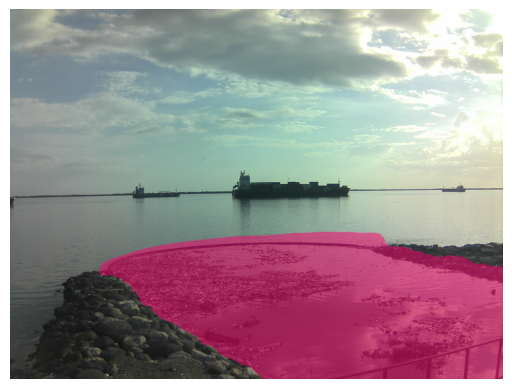

 17%|█▋        | 1/6 [00:26<02:13, 26.73s/it]

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


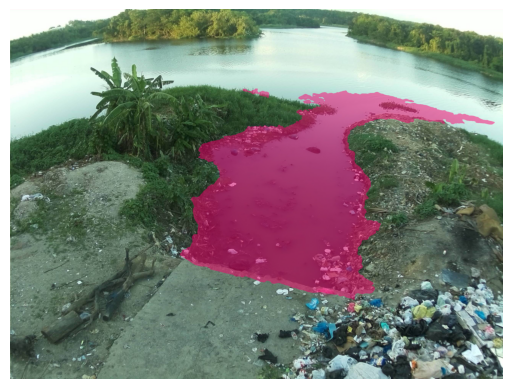

 33%|███▎      | 2/6 [00:54<01:48, 27.21s/it]

loading annotations into memory...
Done (t=1.37s)
creating index...
index created!


100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


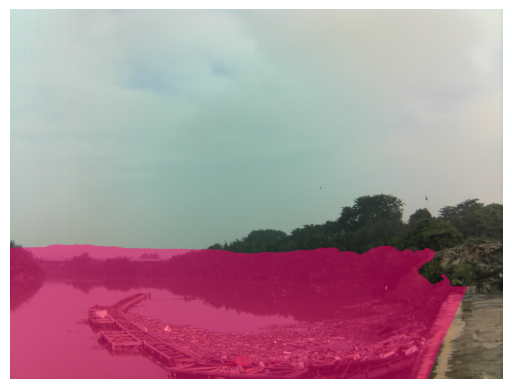

 50%|█████     | 3/6 [01:13<01:11, 23.78s/it]

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


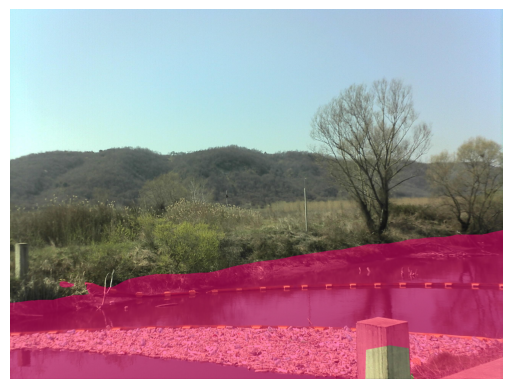

 67%|██████▋   | 4/6 [01:27<00:39, 19.93s/it]

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


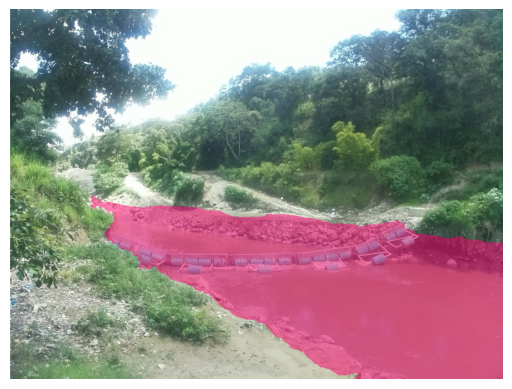

 83%|████████▎ | 5/6 [02:13<00:28, 29.00s/it]

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


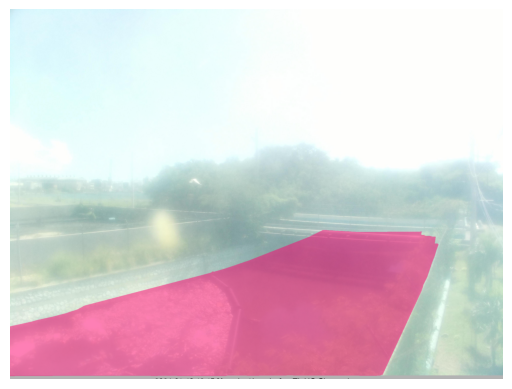

100%|██████████| 6/6 [02:49<00:00, 28.22s/it]


In [11]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt
import torch
import os
from tqdm import tqdm

from visualization import draw_ann
from dataset import get_gt_masks

os.makedirs('./data/combined_gt_masks', exist_ok=True)
for location in tqdm(os.listdir('./data/images')):
    image_folder = f'./data/images/{location}'
    annotations = get_gt_masks('./data/annotations/all_annotations.json', image_folder)
    
    all_gt_masks = []
    for masks, _ in tqdm(annotations.values()):
        masks = resize(masks, (1944, 2592))
        masks = torch.sum(masks, dim=0).unsqueeze(0)
        all_gt_masks.append(masks)

    combined_masks = torch.sum(torch.concat(all_gt_masks, dim=0), dim=0)
    combined_masks = combined_masks > 0

    first_img = os.listdir(image_folder)[0]
    image = read_image(f'{image_folder}/{first_img}')
    image = resize(image, (1944,2592))
    annotated = draw_ann(image, combined_masks.unsqueeze(0), int_colors=[[255, 0, 110]])

    torch.save(combined_masks, f'./data/combined_gt_masks/{location}.pt')
    
    plt.imshow(annotated)
    plt.axis('off')
    plt.show()